In [ ]:
%pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
PROJECT_ROOT = Path.cwd() / "AgriYieldPredictor_real"
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "models"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
def safe_read_csv(p: Path, **kwargs):
    if not p.exists():
        raise FileNotFoundError(f"{p} not found. Place your CSV at this path.")
    return pd.read_csv(p, **kwargs)

def to_safe_colname(name: str) -> str:
    # normalize header names
    return name.strip().lower().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")

In [5]:
fao_path = DATA_DIR / "fao_crop_yields.csv"
core_path = DATA_DIR / "data_core.csv"
weather_path = DATA_DIR / "weather_data.csv"

In [9]:
print("Loading files (expecting exact filenames in ./AgriYieldPredictor_real/data/)...")
# Use engine='python' and on_bad_lines='skip' to handle potential parsing errors
fao_raw = safe_read_csv(fao_path, dtype=str, engine='python', on_bad_lines='skip')    # read as strings first to avoid dtype issues
core_raw = safe_read_csv(core_path)
weather_raw = safe_read_csv(weather_path)

print("Loaded CSV shapes:", "FAO:", fao_raw.shape, "DATA_CORE:", core_raw.shape, "WEATHER:", weather_raw.shape)

Loading files (expecting exact filenames in ./AgriYieldPredictor_real/data/)...
Loaded CSV shapes: FAO: (25064, 14) DATA_CORE: (8000, 9) WEATHER: (8633, 14)


In [10]:
fao_cols_map = {c: to_safe_colname(c) for c in fao_raw.columns}
fao = fao_raw.rename(columns=fao_cols_map)

# Expected safe columns: area, item, year, value
# Possible names from input: area, item, year, value (but they may be like 'area', 'item', 'year', 'value')
# Try to find the right columns
possible_area_cols = [c for c in fao.columns if 'area' in c]
possible_item_cols = [c for c in fao.columns if c.startswith('item') or 'item'==c]
possible_year_cols = [c for c in fao.columns if c.startswith('year')]
possible_value_cols = [c for c in fao.columns if c in ('value','val','yield') or 'value' in c]

def first_or_none(lst):
    return lst[0] if lst else None

area_col = first_or_none(possible_area_cols)
item_col = first_or_none(possible_item_cols)
year_col = first_or_none(possible_year_cols)
value_col = first_or_none(possible_value_cols)

if not all([area_col, item_col, year_col, value_col]):
    print("DEBUG: detected fao columns:", fao.columns.tolist())
    raise ValueError("Could not detect necessary FAO columns (Area, Item, Year, Value). Please check headers.")

# keep only necessary cols
fao = fao[[area_col, item_col, year_col, value_col]].copy()
fao.columns = ['area', 'item', 'year', 'yield_value']
# convert types
fao['year'] = pd.to_numeric(fao['year'], errors='coerce').astype('Int64')
fao['yield_value'] = pd.to_numeric(fao['yield_value'], errors='coerce')
fao = fao.dropna(subset=['area','item','year','yield_value'])
fao['area'] = fao['area'].str.strip()
fao['item'] = fao['item'].str.strip()
print("FAO processed rows:", fao.shape[0])

# DATA_CORE: expected columns from your header
# "Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name"
core = core_raw.rename(columns={c: c.strip() for c in core_raw.columns})
# normalize to lowercase underscored
core.columns = [to_safe_colname(c) for c in core.columns]

# Standardize expected core columns
expected_core_cols = {
    'temperature': None,
    'humidity': None,
    'moisture': None,
    'soil_type': None,
    'crop_type': None,
    'nitrogen': None,
    'potassium': None,
    'phosphorous': None,
    'fertilizer_name': None
}
for ec in expected_core_cols.keys():
    if ec in core.columns:
        expected_core_cols[ec] = ec
    else:
        # try fuzzy or similar matches
        for c in core.columns:
            if ec.split('_')[0] in c:
                expected_core_cols[ec] = c
                break

# If some are still missing, print warning but continue
missing_core = [k for k,v in expected_core_cols.items() if v is None]
if missing_core:
    print("Warning: these expected DATA_CORE columns were not found exactly:", missing_core)
    print("Detected DATA_CORE columns:", core.columns.tolist())

# rename columns in core to canonical names if found
rename_core = {v:k for k,v in expected_core_cols.items() if v is not None}
core = core.rename(columns=rename_core)
# ensure numeric columns are numeric
for ncol in ['temperature','humidity','moisture','nitrogen','potassium','phosphorous']:
    if ncol in core.columns:
        core[ncol] = pd.to_numeric(core[ncol], errors='coerce')

# Trim crop_type and soil_type text
if 'crop_type' in core.columns:
    core['crop_type'] = core['crop_type'].astype(str).str.strip()
if 'soil_type' in core.columns:
    core['soil_type'] = core['soil_type'].astype(str).str.strip()

print("DATA_CORE processed rows:", core.shape[0])

# WEATHER: rename and extract useful pieces
weather = weather_raw.rename(columns={c: c.strip() for c in weather_raw.columns})
weather.columns = [to_safe_colname(c) for c in weather.columns]
# map likely columns
# precipitation -> precipitation_in or precipitation
precip_col_candidates = [c for c in weather.columns if 'precip' in c]
start_col_candidates = [c for c in weather.columns if 'starttime' in c or 'start' in c]
state_col_candidates = [c for c in weather.columns if 'state' in c]
city_col_candidates = [c for c in weather.columns if 'city' in c]
severity_candidates = [c for c in weather.columns if 'severity' in c]

precip_col = first_or_none(precip_col_candidates)
start_col = first_or_none(start_col_candidates)
state_col = first_or_none(state_col_candidates)
city_col = first_or_none(city_col_candidates)
severity_col = first_or_none(severity_candidates)

if start_col is None:
    # try any date-like column
    for c in weather.columns:
        if 'time' in c or 'date' in c:
            start_col = c
            break

if precip_col is None:
    print("Warning: precipitation column not found in weather; precipitation aggregation will be skipped.")

# Keep useful columns if present
keep_cols = [c for c in [precip_col, start_col, state_col, city_col, severity_col, 'locationlat','locationlng'] if c]
weather_small = weather[keep_cols].copy()

# Convert start time to datetime and derive year
if start_col:
    weather_small['start_dt'] = pd.to_datetime(weather_small[start_col], errors='coerce')
    weather_small['year'] = weather_small['start_dt'].dt.year
else:
    weather_small['year'] = np.nan

# Convert precipitation to numeric (it's likely in inches in header)
if precip_col:
    weather_small[precip_col] = pd.to_numeric(weather_small[precip_col], errors='coerce')
    # convert inches to mm (1 in = 25.4 mm)
    weather_small['precip_mm'] = weather_small[precip_col] * 25.4
else:
    weather_small['precip_mm'] = np.nan

# severity numeric mapping if present
if severity_col:
    # Try to coerce numeric, else map low/medium/high -> numbers
    def map_sev(x):
        try:
            return float(x)
        except:
            s = str(x).lower()
            if 'low' in s: return 1.0
            if 'medium' in s: return 2.0
            if 'high' in s: return 3.0
            return np.nan
    weather_small['severity_num'] = weather_small[severity_col].apply(map_sev)
else:
    weather_small['severity_num'] = np.nan

# Aggregate weather to state-year (or city-year fallback)
group_on = 'state' if state_col else ('city' if city_col else None)
if group_on:
    grp_cols = [group_on, 'year']
    agg = weather_small.groupby(grp_cols).agg(
        total_precip_mm = ('precip_mm', 'sum'),
        mean_precip_mm = ('precip_mm', 'mean'),
        avg_severity = ('severity_num', 'mean'),
        event_count = (precip_col, 'count') if precip_col else ('start_dt','count')
    ).reset_index().rename(columns={group_on: 'area_state'})
    print("Aggregated weather shape:", agg.shape)
else:
    # If no state/city, aggregate by year only
    agg = weather_small.groupby(['year']).agg(
        total_precip_mm = ('precip_mm', 'sum'),
        mean_precip_mm = ('precip_mm', 'mean'),
        avg_severity = ('severity_num', 'mean'),
        event_count = (precip_col, 'count') if precip_col else ('start_dt','count')
    ).reset_index()
    agg = agg.rename(columns={'year':'year'})
    print("Aggregated weather by year only:", agg.shape)

FAO processed rows: 22917
Detected DATA_CORE columns: ['temparature', 'humidity', 'moisture', 'soil_type', 'crop_type', 'nitrogen', 'potassium', 'phosphorous', 'fertilizer_name']
DATA_CORE processed rows: 8000
Aggregated weather shape: (17, 6)


In [11]:
fao_merge = fao.copy()
fao_merge['area_clean'] = fao_merge['area'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.strip()

if 'area_state' in agg.columns:
    agg['area_state_clean'] = agg['area_state'].astype(str).str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.strip()
    merged = fao_merge.merge(agg, left_on=['area_clean','year'], right_on=['area_state_clean','year'], how='left')
else:
    # weather aggregated by year only
    merged = fao_merge.merge(agg, left_on='year', right_on='year', how='left')

print("After merging FAO with weather, rows:", merged.shape[0])

# Next, merge DATA_CORE
# If core has area/state info, use it; try to detect
possible_core_area_cols = [c for c in core.columns if c in ('area','state','city','location','location_name')]
core_area_col = first_or_none(possible_core_area_cols)

if core_area_col:
    core['area_clean'] = core[core_area_col].astype(str).str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).str.strip()
    if 'area_state_clean' in merged.columns:
        merged = merged.merge(core, left_on='area_clean', right_on='area_clean', how='left', suffixes=('','_core'))
    else:
        # try merging on crop/type and year if available
        if 'crop_type' in core.columns:
            merged = merged.merge(core, left_on='item', right_on='crop_type', how='left', suffixes=('','_core'))
        else:
            merged = merged.merge(core, left_index=True, right_index=True, how='left', suffixes=('','_core'))
else:
    # no area in core -> merge on crop matches if possible
    if 'crop_type' in core.columns:
        merged = merged.merge(core, left_on='item', right_on='crop_type', how='left', suffixes=('','_core'))
    else:
        # append core rows as features via simple stats (fallback) - here we attempt to broadcast mean values
        numeric_core = core.select_dtypes(include=[np.number])
        if not numeric_core.empty:
            core_means = numeric_core.mean().to_dict()
            for k,v in core_means.items():
                merged[k] = merged.get(k, v)
        else:
            print("Warning: data_core could not be merged by area or crop. Proceeding without core features.")

print("After merging with DATA_CORE, rows:", merged.shape[0])

After merging FAO with weather, rows: 22917
After merging with DATA_CORE, rows: 22917


In [12]:
df = merged.copy()

# Use FAO yield as target
df = df.rename(columns={'yield_value':'yield'})
df['yield'] = pd.to_numeric(df['yield'], errors='coerce')
df = df.dropna(subset=['yield'])
print("Rows with valid yield:", df.shape[0])

# Example engineered features:
# - growing_season_index: total_precip_mm * avg_temp (if exist) with penalty for deviation from ideal temp (25C)
if 'total_precip_mm' in df.columns and 'temperature' in df.columns:
    df['growing_season_index'] = df['total_precip_mm'] * df['temperature'] / (1 + (df['temperature'] - 25).abs())
elif 'total_precip_mm' in df.columns:
    df['growing_season_index'] = df['total_precip_mm']
else:
    df['growing_season_index'] = 0.0

# heat_day_ratio if temperature data present (approx)
if 'temperature' in df.columns:
    df['heat_day_ratio'] = (df['temperature'] >= 30).astype(int)  # simplistic flag
else:
    df['heat_day_ratio'] = 0.0

# NPK features
for nut in ['nitrogen','potassium','phosphorous']:
    if nut in df.columns:
        df[nut] = pd.to_numeric(df[nut], errors='coerce')
df_nuts = [c for c in ['nitrogen','potassium','phosphorous'] if c in df.columns]
if df_nuts:
    df['npk_sum'] = df[df_nuts].sum(axis=1, skipna=True)
    df['npk_prod'] = df[df_nuts].prod(axis=1, skipna=True)
else:
    df['npk_sum'] = 0.0
    df['npk_prod'] = 0.0

# Fill numeric missing values with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if c == 'year': continue
    df[c] = df[c].fillna(df[c].median())

# Categorical tidy-up: item (FAO crop), soil_type, fertilizer_name
if 'item' in df.columns:
    df['item'] = df['item'].astype(str).str.strip()
if 'soil_type' in df.columns:
    df['soil_type'] = df['soil_type'].astype(str).fillna('Unknown').str.strip()
if 'fertilizer_name' in df.columns:
    df['fertilizer_name'] = df['fertilizer_name'].astype(str).fillna('Unknown').str.strip()

Rows with valid yield: 22917


In [13]:
drop_cols = ['area','area_clean','area_state','area_state_clean','start_dt','locationlat','locationlng','item_core','crop_type','area_core']
drop_cols = [c for c in drop_cols if c in df.columns]
feature_df = df.drop(columns=drop_cols)

# choose features: numeric + categorical encoded
# Create a ready X,y
target = 'yield'
feature_candidates = feature_df.columns.tolist()
# remove the target and year to avoid leakage
for c in [target,'year']:
    if c in feature_candidates:
        feature_candidates.remove(c)

# Choose a reasonable subset: numeric + important named columns
numeric = feature_df.select_dtypes(include=[np.number]).columns.tolist()
# ensure we include the engineered features
for col in ['growing_season_index','npk_sum','npk_prod','heat_day_ratio','total_precip_mm','mean_precip_mm','avg_severity','event_count']:
    if col in feature_df.columns and col not in numeric:
        numeric.append(col)

# categorical to encode (small cardinality)
categorical = []
for c in ['item','soil_type','fertilizer_name','state','city']:
    if c in feature_df.columns:
        categorical.append(c)

X_num = feature_df[numeric].copy()
X_cat = feature_df[categorical].copy() if categorical else pd.DataFrame(index=feature_df.index)

# One-hot encode small-cardinality categoricals
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)
X = pd.concat([X_num.reset_index(drop=True), X_cat_encoded.reset_index(drop=True)], axis=1)
y = feature_df[target].astype(float).reset_index(drop=True)

print("Final feature matrix shape:", X.shape)

# If too few rows (due to merges), warn
if X.shape[0] < 20:
    print("Warning: small dataset after merging (rows < 20). Model results may be unreliable. Rows:", X.shape[0])

Final feature matrix shape: (22917, 168)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [17]:
y_pred = rf.predict(X_test_scaled)
# Calculate RMSE manually by taking the square root of the MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nModel evaluation on test set:")
print(f"Rows in train: {X_train.shape[0]}, test: {X_test.shape[0]}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


Model evaluation on test set:
Rows in train: 18333, test: 4584
RMSE: 4430.2985
MAE: 468.9924
R2: 1.0000


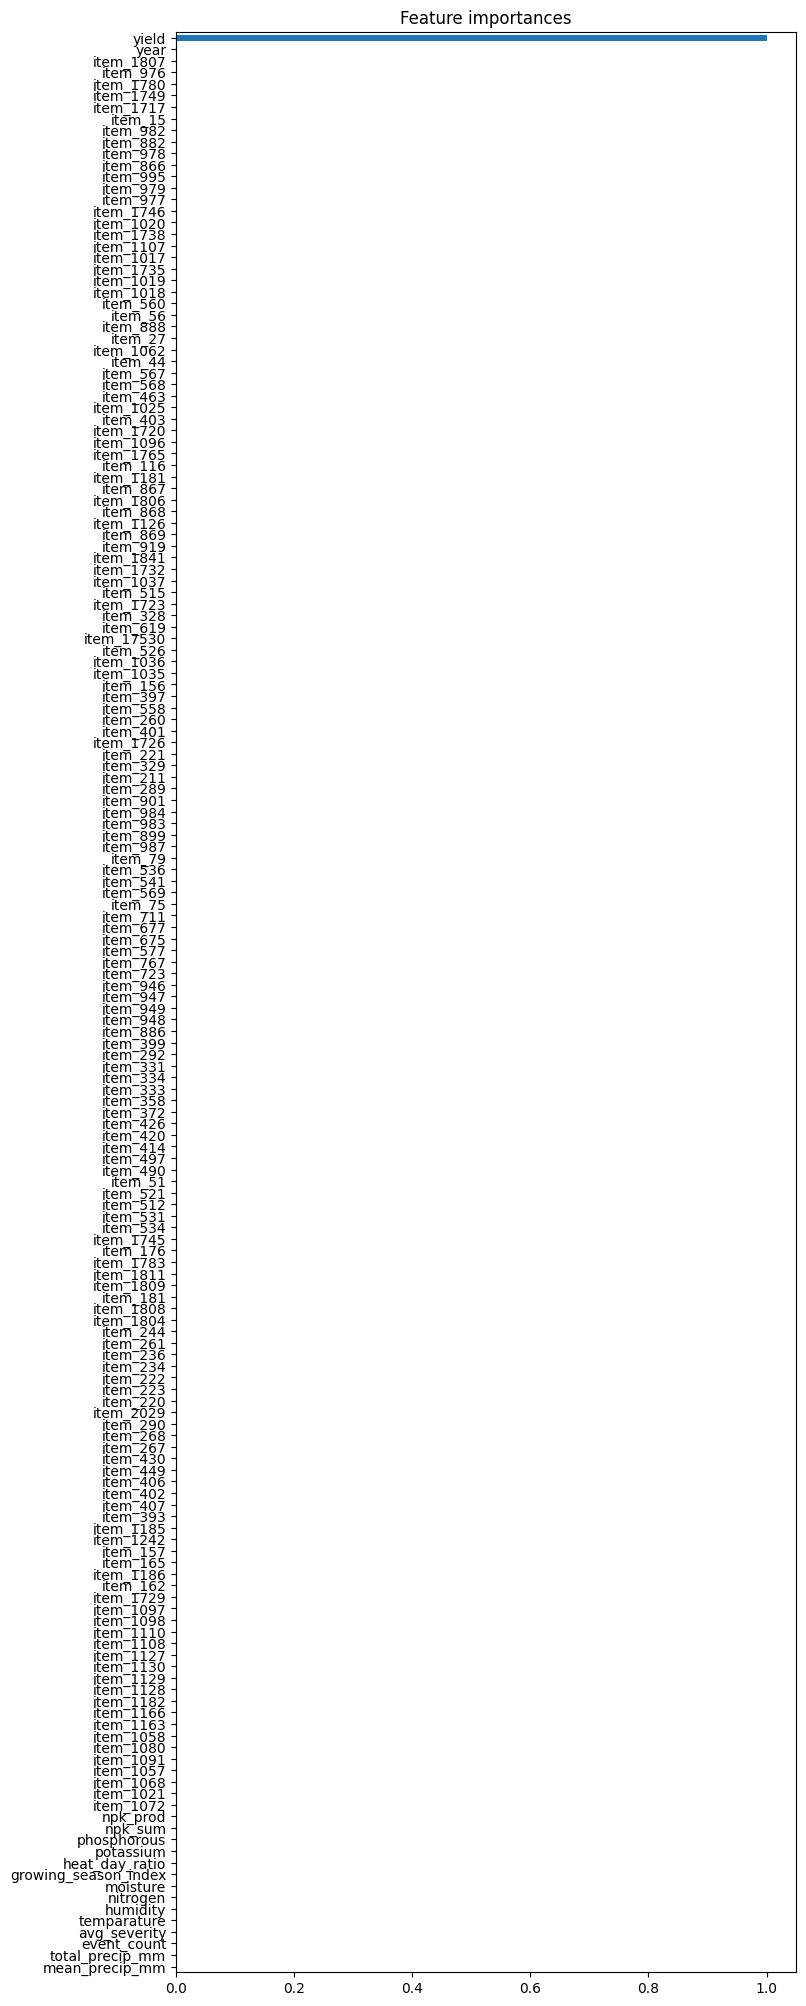

In [18]:
try:
    fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
    plt.figure(figsize=(8, max(4, 0.15*len(fi))))
    fi.plot(kind='barh')
    plt.title("Feature importances")
    plt.show()
except Exception as e:
    print("Could not plot feature importances:", e)

In [19]:
joblib.dump(rf, MODEL_DIR / "rf_crop_yield_model.joblib")
joblib.dump(scaler, MODEL_DIR / "scaler.joblib")
print("Saved model and scaler to:", MODEL_DIR)

Saved model and scaler to: /content/AgriYieldPredictor_real/models


In [20]:
print("\n--- Interactive prediction ---")
print("You will be asked for required fields. If you don't know a value, press enter to use median/default.\n")

# Prepare reference lists for available items/crops and soil types
available_crops = sorted(df['item'].dropna().unique()) if 'item' in df.columns else []
available_soil = sorted(df['soil_type'].dropna().unique()) if 'soil_type' in df.columns else []

def prompt_with_default(prompt_text, default_val):
    v = input(f"{prompt_text} (default={default_val}): ").strip()
    return v if v != "" else default_val

# Ask for inputs
# numeric features: temperature, humidity, moisture, nitrogen, potassium, phosphorous, total_precip_mm
inputs = {}
# temperature
if 'temperature' in X.columns or 'temperature' in feature_df.columns:
    default_temp = float(feature_df['temperature'].median()) if 'temperature' in feature_df.columns else 25.0
    inputs['temperature'] = float(prompt_with_default("Temperature (°C)", default_temp))
# humidity
if 'humidity' in X.columns or 'humidity' in feature_df.columns:
    default_h = float(feature_df['humidity'].median()) if 'humidity' in feature_df.columns else 50.0
    inputs['humidity'] = float(prompt_with_default("Humidity (%)", default_h))
# moisture
if 'moisture' in X.columns or 'moisture' in feature_df.columns:
    default_m = float(feature_df['moisture'].median()) if 'moisture' in feature_df.columns else 20.0
    inputs['moisture'] = float(prompt_with_default("Soil moisture (%)", default_m))
# N, P, K
for nut in ['nitrogen','potassium','phosphorous']:
    if nut in X.columns or nut in feature_df.columns:
        default_n = float(feature_df[nut].median()) if nut in feature_df.columns else 10.0
        inputs[nut] = float(prompt_with_default(f"{nut.title()} (e.g., kg/ha or % depending on your dataset)", default_n))
# total_precip_mm
if 'total_precip_mm' in X.columns:
    default_prec = float(feature_df['total_precip_mm'].median()) if 'total_precip_mm' in feature_df.columns else 500.0
    inputs['total_precip_mm'] = float(prompt_with_default("Total yearly precipitation (mm)", default_prec))
# soil_type
chosen_soil = None
if 'soil_type' in X.columns:
    print("Available soil types (detected):", available_soil[:12])
    chosen_soil = prompt_with_default("Soil type (enter one of the above or new)", available_soil[0] if available_soil else "Unknown")
    inputs['soil_type'] = chosen_soil
# crop/item
chosen_crop = None
if available_crops:
    print("Available crops (detected):", available_crops[:30])
    chosen_crop = prompt_with_default("Crop (enter name exactly as in FAO 'Item')", available_crops[0])
    inputs['item'] = chosen_crop
else:
    # if no available crops, ask user
    chosen_crop = prompt_with_default("Crop (enter crop name)", "Unknown")
    inputs['item'] = chosen_crop

# Now assemble input vector with same columns as X
input_row = pd.DataFrame(columns=X.columns)
input_row.loc[0] = 0.0  # initialize zeros

# fill numeric values
for k,v in inputs.items():
    if k in input_row.columns:
        input_row.at[0,k] = float(v)

# engineered fields if needed
# npk_sum and npk_prod
if 'npk_sum' in input_row.columns:
    n = inputs.get('nitrogen', 0.0)
    p = inputs.get('phosphorous', 0.0)
    k_ = inputs.get('potassium', 0.0)
    input_row.at[0,'npk_sum'] = n + p + k_
if 'npk_prod' in input_row.columns:
    input_row.at[0,'npk_prod'] = (inputs.get('nitrogen',0.0) * inputs.get('potassium',0.0) * inputs.get('phosphorous',0.0))

# growing_season_index
if 'growing_season_index' in input_row.columns:
    if 'total_precip_mm' in inputs and 'temperature' in inputs:
        t = inputs['temperature']
        prec = inputs['total_precip_mm']
        input_row.at[0,'growing_season_index'] = prec * t / (1 + abs(t - 25))
    elif 'total_precip_mm' in inputs:
        input_row.at[0,'growing_season_index'] = inputs['total_precip_mm']

# categorical columns: item, soil_type, fertilizer_name -> set corresponding one-hot columns if present
for col in X.columns:
    if col.startswith('item_'):
        cat = col.replace('item_','')
        if inputs.get('item', '').lower() == cat.lower():
            input_row.at[0,col] = 1
    if col.startswith('soil_type_') and 'soil_type' in inputs:
        cat = col.replace('soil_type_','')
        if inputs.get('soil_type','').lower() == cat.lower():
            input_row.at[0,col] = 1
    if col.startswith('fertilizer_name_') and 'fertilizer_name' in inputs:
        cat = col.replace('fertilizer_name_','')
        if inputs.get('fertilizer_name','').lower() == cat.lower():
            input_row.at[0,col] = 1

# scale and predict
input_scaled = scaler.transform(input_row.values.astype(float))
predicted_yield = rf.predict(input_scaled)[0]
print("\nPredicted yield (same units as FAO 'Value' column): {:.2f}".format(predicted_yield))


--- Interactive prediction ---
You will be asked for required fields. If you don't know a value, press enter to use median/default.

Humidity (%) (default=nan): 70
Soil moisture (%) (default=nan): 23
Nitrogen (e.g., kg/ha or % depending on your dataset) (default=nan): 34
Potassium (e.g., kg/ha or % depending on your dataset) (default=nan): 56
Phosphorous (e.g., kg/ha or % depending on your dataset) (default=nan): 67
Total yearly precipitation (mm) (default=nan): 234
Available crops (detected): ['1016', '1017', '1018', '1019', '1020', '1021', '1025', '1035', '1036', '1037', '1057', '1058', '1062', '1068', '1072', '1080', '1091', '1096', '1097', '1098', '1107', '1108', '1110', '1126', '1127', '1128', '1129', '1130', '116', '1163']
Crop (enter name exactly as in FAO 'Item') (default=1016): 1016

Predicted yield (same units as FAO 'Value' column): 16.48
